In [1]:
import tensorflow as tf
import numpy as np
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Flatten
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn import metrics
import matplotlib.pyplot as plt
import os
from PIL import Image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

In [2]:
# ================== CONFIGURAÇÃO ==================
IMAGE_SIZE = (128, 128)  # Tamanho das imagens
BATCH_SIZE = 32
NUM_CLASSES = 8  # Altere para número de suas classes
EPOCHS = 50

#preparo de dados

def load_images_from_folder(folder_path):
    images = []
    labels = []

    #verificar se pasta existe
    if not os.path.exists(folder_path):
        print(f"ERRO: Pasta '{folder_path}' não encontrada!")
        print("Crie a pasta com esta estrutura:")
        print("pasta de teste/")
        print("├── classe1/")
        print("│   ├── img1.jpg")
        print("│   └── img2.jpg")
        print("├── classe2/")
        print("│   ├── img1.jpg")
        print("│   └── img2.jpg")
        print("└── classe3/")
        return np.array([]), np.array([]), []
    
    class_names = sorted([d for d in os.listdir(folder_path) 
                         if os.path.isdir(os.path.join(folder_path, d))])
    
    if not class_names:
        print(f"ERRO: Nenhuma subpasta encontrada em '{folder_path}'")
        return np.array([]), np.array([]), []
    
    print(f"Encontradas {len(class_names)} classes: {class_names}")
    
    for class_idx, class_name in enumerate(class_names):
        class_path = os.path.join(folder_path, class_name)
        image_count = 0
        
        for image_file in os.listdir(class_path):
            if image_file.lower().endswith(('.jpg', '.jpeg', '.png', '.bmp')):
                image_path = os.path.join(class_path, image_file)
                try:
                    img = Image.open(image_path).convert('RGB')
                    img = img.resize(IMAGE_SIZE)
                    img_array = np.array(img) / 255.0  # Normalizar [0, 1]
                    images.append(img_array)
                    labels.append(class_idx)
                    image_count += 1
                except Exception as e:
                    print(f"Erro ao carregar {image_path}: {e}")
        
        print(f"Classe '{class_name}': {image_count} imagens")
    
    return np.array(images), np.array(labels), class_names

In [3]:
# ================== DIAGNÓSTICO DOS DADOS ==================
def diagnosticar_dados(X, y, class_names):
    print("\n" + "="*50)
    print("DIAGNÓSTICO COMPLETO DOS DADOS")
    print("="*50)
    
    if len(X) == 0:
        print("❌ NENHUMA IMAGEM CARREGADA!")
        return False
    
    print(f"✅ Total de imagens: {len(X)}")
    print(f"✅ Número de classes: {len(class_names)}")
    print(f"✅ Formato das imagens: {X[0].shape}")
    
    # Distribuição de classes
    print("\n📊 DISTRIBUIÇÃO DAS CLASSES:")
    for i, class_name in enumerate(class_names):
        count = np.sum(y == i)
        porcentagem = count / len(y) * 100
        print(f"   {class_name}: {count} imagens ({porcentagem:.1f}%)")
    
    # Verificar balanceamento
    counts = [np.sum(y == i) for i in range(len(class_names))]
    min_count = min(counts)
    max_count = max(counts)
    
    if min_count == 0:
        print("❌ ALERTA: Alguma classe não tem nenhuma imagem!")
        return False
    
    if max_count / min_count > 3:
        print("⚠️  ALERTA: Classes desbalanceadas (mais de 3x diferença)")
    else:
        print("✅ Classes relativamente balanceadas")
    
    # Verificar normalização
    print(f"\n🔍 VALORES DOS PIXELS:")
    print(f"   Mínimo: {X.min():.3f} (deve ser próximo de 0)")
    print(f"   Máximo: {X.max():.3f} (deve ser próximo de 1)")
    print(f"   Média: {X.mean():.3f}")
    
    if X.min() < 0 or X.max() > 1:
        print("❌ ERRO: Imagens não estão normalizadas entre 0 e 1!")
        return False
    else:
        print("✅ Imagens corretamente normalizadas")
    
    # # Mostrar exemplo de imagens
    # print(f"\n👀 EXEMPLO DE IMAGENS (primeiras 3):")
    # plt.figure(figsize=(12, 4))
    # for i in range(min(3, len(X))):
    #     plt.subplot(1, 3, i+1)
    #     plt.imshow(X[i])
    #     plt.title(f'Classe: {class_names[y[i]]}\nShape: {X[i].shape}')
    #     plt.axis('off')
    # plt.tight_layout()
    # plt.show()
    
    return True

In [4]:
# ================== PLOTAR GRÁFICOS ==================
def plot_training_history(history, hidden_units):
    plt.figure(figsize=(15, 5))
    
    # Gráfico de Acurácia
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy', linewidth=2)
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy', linewidth=2)
    plt.title(f'Training and Validation Accuracy\n({hidden_units} units)', fontsize=14)
    plt.xlabel('Epochs', fontsize=12)
    plt.ylabel('Accuracy', fontsize=12)
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Gráfico de Loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss', linewidth=2)
    plt.plot(history.history['val_loss'], label='Validation Loss', linewidth=2)
    plt.title(f'Training and Validation Loss\n({hidden_units} units)', fontsize=14)
    plt.xlabel('Epochs', fontsize=12)
    plt.ylabel('Loss', fontsize=12)
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()


In [5]:
def create_img_cnn(input_shape, num_class, hidden_units=128):
    model = Sequential([
        # Bloco 1
        layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape, padding='same'),
        layers.BatchNormalization(),
        layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.25),
        
        # Bloco 2
        layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.Conv2D(64, (3, 3), activation='relu',  padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.25),
        
        # Bloco 3
        layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.Conv2D(128, (3, 3), activation='relu',  padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.25),

        # Bloco 4
        layers.Conv2D(256, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.Conv2D(256, (3, 3), activation='relu',  padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.25),
        
        layers.Flatten(),
        
        # Dense layers
        layers.Dense(512, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.5),
        
        layers.Dense(256, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.5),

        layers.Dense(num_class, activation='softmax')
    ])
    
    model.compile(optimizer=Adam(learning_rate=0.00005),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model

Carregando imagens...
Encontradas 8 classes: ['borda_4,22', 'borda_4,88', 'borda_5,63', 'borda_6,65', 'centro_4,22', 'centro_4,88', 'centro_5,63', 'centro_6,65']
Classe 'borda_4,22': 800 imagens
Classe 'borda_4,88': 800 imagens
Classe 'borda_5,63': 800 imagens
Classe 'borda_6,65': 810 imagens
Classe 'centro_4,22': 800 imagens
Classe 'centro_4,88': 810 imagens
Classe 'centro_5,63': 800 imagens
Classe 'centro_6,65': 800 imagens

DIAGNÓSTICO COMPLETO DOS DADOS
✅ Total de imagens: 6420
✅ Número de classes: 8
✅ Formato das imagens: (128, 128, 3)

📊 DISTRIBUIÇÃO DAS CLASSES:
   borda_4,22: 800 imagens (12.5%)
   borda_4,88: 800 imagens (12.5%)
   borda_5,63: 800 imagens (12.5%)
   borda_6,65: 810 imagens (12.6%)
   centro_4,22: 800 imagens (12.5%)
   centro_4,88: 810 imagens (12.6%)
   centro_5,63: 800 imagens (12.5%)
   centro_6,65: 800 imagens (12.5%)
✅ Classes relativamente balanceadas

🔍 VALORES DOS PIXELS:
   Mínimo: 0.000 (deve ser próximo de 0)
   Máximo: 1.000 (deve ser próximo de 1)

c:\Users\chena\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



📋 Summary do modelo (32 unidades):


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 128, 128, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 128, 128, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 128, 128, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 128, 128, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 64, 64, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 64, 64, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 64, 64, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 64, 64, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 32, 32, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 32, 32, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 32, 32, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 32, 32, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 16, 16, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 16, 16, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 16, 16, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 9,701,672 (37.01 MB)

 Trainable params: 9,698,216 (37.00 MB)

 Non-trainable params: 3,456 (13.50 KB)

c:\Users\chena\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
120/120 ━━━━━━━━━━━━━━━━━━━━ 321s 3s/step - accuracy: 0.1702 - loss: 3.0877 - val_accuracy: 0.1262 - val_loss: 2.9215 - learning_rate: 5.0000e-05
Epoch 2/50
  1/120 ━━━━━━━━━━━━━━━━━━━━ 4:19 2s/step - accuracy: 0.2812 - loss: 2.0095

c:\Users\chena\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\trainers\epoch_iterator.py:116: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


120/120 ━━━━━━━━━━━━━━━━━━━━ 20s 148ms/step - accuracy: 0.2812 - loss: 2.0095 - val_accuracy: 0.1262 - val_loss: 2.9372 - learning_rate: 5.0000e-05
Epoch 3/50
120/120 ━━━━━━━━━━━━━━━━━━━━ 275s 2s/step - accuracy: 0.2285 - loss: 2.8219 - val_accuracy: 0.1246 - val_loss: 4.4639 - learning_rate: 5.0000e-05
Epoch 4/50
120/120 ━━━━━━━━━━━━━━━━━━━━ 20s 147ms/step - accuracy: 0.1875 - loss: 2.6809 - val_accuracy: 0.1246 - val_loss: 4.4805 - learning_rate: 5.0000e-05
Epoch 5/50
120/120 ━━━━━━━━━━━━━━━━━━━━ 277s 2s/step - accuracy: 0.2539 - loss: 2.6354 - val_accuracy: 0.1246 - val_loss: 6.1395 - learning_rate: 5.0000e-05
Epoch 6/50
120/120 ━━━━━━━━━━━━━━━━━━━━ 20s 146ms/step - accuracy: 0.3125 - loss: 2.7667 - val_accuracy: 0.1246 - val_loss: 6.1171 - learning_rate: 5.0000e-05
Epoch 7/50
120/120 ━━━━━━━━━━━━━━━━━━━━ 277s 2s/step - accuracy: 0.2694 - loss: 2.5130 - val_accuracy: 0.1246 - val_loss: 5.7488 - learning_rate: 1.0000e-05
Epoch 8/50
120/120 ━━━━━━━━━━━━━━━━━━━━ 20s 148ms/step - accura

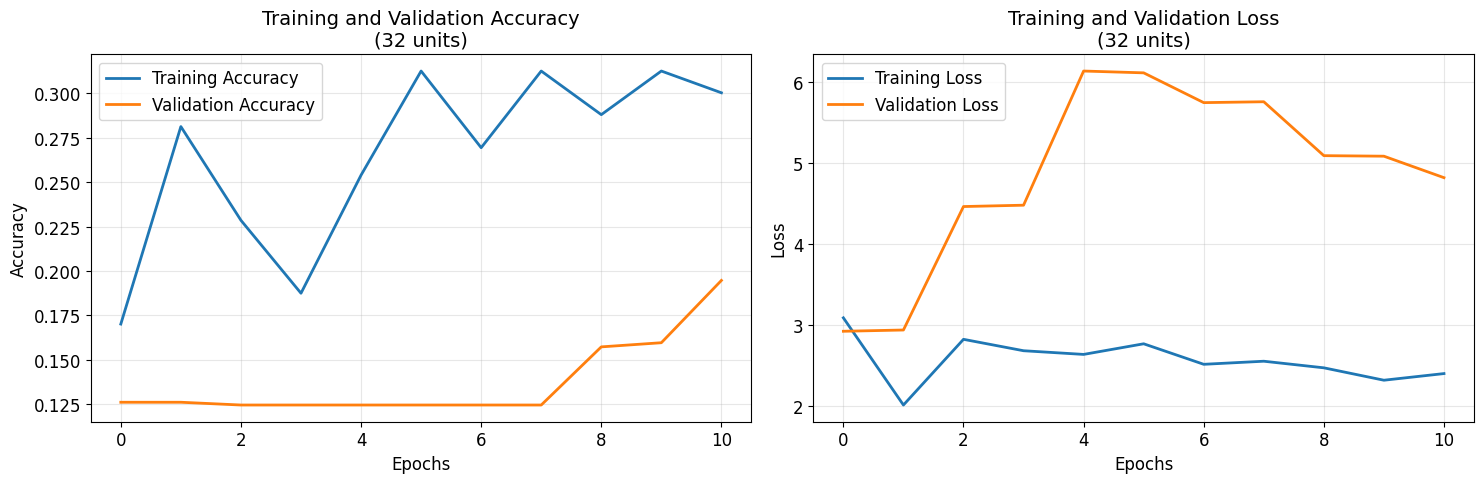

📊 Resultados para 32 unidades:
   Melhor acurácia treino: 0.3125
   Melhor acurácia validação: 0.1947

🧪 Testando com 64 unidades ocultas...

📋 Summary do modelo (64 unidades):


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_8 (Conv2D)               │ (None, 128, 128, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 128, 128, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 128, 128, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_11          │ (None, 128, 128, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 64, 64, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_12          │ (None, 64, 64, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 64, 64, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_13          │ (None, 64, 64, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_12 (Conv2D)              │ (None, 32, 32, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_14          │ (None, 32, 32, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 32, 32, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_15          │ (None, 32, 32, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ (None, 16, 16, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_16          │ (None, 16, 16, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_15 (Conv2D)              │ (None, 16, 16, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 9,701,672 (37.01 MB)

 Trainable params: 9,698,216 (37.00 MB)

 Non-trainable params: 3,456 (13.50 KB)

Epoch 1/50
120/120 ━━━━━━━━━━━━━━━━━━━━ 291s 2s/step - accuracy: 0.1822 - loss: 3.0787 - val_accuracy: 0.1262 - val_loss: 3.1634 - learning_rate: 5.0000e-05
Epoch 2/50
120/120 ━━━━━━━━━━━━━━━━━━━━ 20s 150ms/step - accuracy: 0.4375 - loss: 2.2650 - val_accuracy: 0.1262 - val_loss: 3.1832 - learning_rate: 5.0000e-05
Epoch 3/50
120/120 ━━━━━━━━━━━━━━━━━━━━ 276s 2s/step - accuracy: 0.2241 - loss: 2.8233 - val_accuracy: 0.1246 - val_loss: 5.4875 - learning_rate: 5.0000e-05
Epoch 4/50
120/120 ━━━━━━━━━━━━━━━━━━━━ 20s 149ms/step - accuracy: 0.1875 - loss: 2.6815 - val_accuracy: 0.1246 - val_loss: 5.4869 - learning_rate: 5.0000e-05
Epoch 5/50
120/120 ━━━━━━━━━━━━━━━━━━━━ 276s 2s/step - accuracy: 0.2586 - loss: 2.6520 - val_accuracy: 0.1238 - val_loss: 7.0566 - learning_rate: 5.0000e-05
Epoch 6/50
120/120 ━━━━━━━━━━━━━━━━━━━━ 20s 149ms/step - accuracy: 0.2812 - loss: 2.7186 - val_accuracy: 0.1238 - val_loss: 7.0500 - learning_rate: 1.0000e-05
Epoch 7/50
120/120 ━━━━━━━━━━━━━━━━━━━━ 276s 2s/step

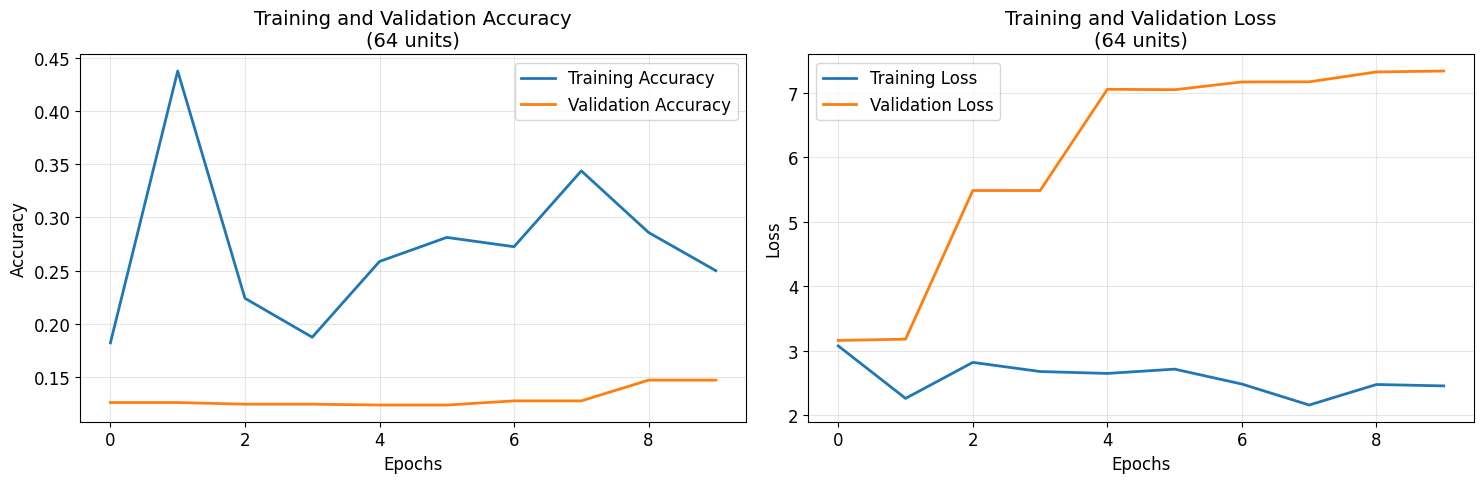

📊 Resultados para 64 unidades:
   Melhor acurácia treino: 0.4375
   Melhor acurácia validação: 0.1472

🧪 Testando com 128 unidades ocultas...

📋 Summary do modelo (128 unidades):


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_16 (Conv2D)              │ (None, 128, 128, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_20          │ (None, 128, 128, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_17 (Conv2D)              │ (None, 128, 128, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_21          │ (None, 128, 128, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_18 (Conv2D)              │ (None, 64, 64, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_22          │ (None, 64, 64, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_19 (Conv2D)              │ (None, 64, 64, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_23          │ (None, 64, 64, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_20 (Conv2D)              │ (None, 32, 32, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_24          │ (None, 32, 32, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_21 (Conv2D)              │ (None, 32, 32, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_25          │ (None, 32, 32, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_14 (Dropout)            │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_22 (Conv2D)              │ (None, 16, 16, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_26          │ (None, 16, 16, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_23 (Conv2D)              │ (None, 16, 16, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 9,701,672 (37.01 MB)

 Trainable params: 9,698,216 (37.00 MB)

 Non-trainable params: 3,456 (13.50 KB)

Epoch 1/50
120/120 ━━━━━━━━━━━━━━━━━━━━ 300s 2s/step - accuracy: 0.1723 - loss: 3.1316 - val_accuracy: 0.1262 - val_loss: 3.8142 - learning_rate: 5.0000e-05
Epoch 2/50
120/120 ━━━━━━━━━━━━━━━━━━━━ 19s 144ms/step - accuracy: 0.2188 - loss: 2.9207 - val_accuracy: 0.1262 - val_loss: 3.8389 - learning_rate: 5.0000e-05
Epoch 3/50
120/120 ━━━━━━━━━━━━━━━━━━━━ 278s 2s/step - accuracy: 0.2348 - loss: 2.7738 - val_accuracy: 0.1262 - val_loss: 4.4639 - learning_rate: 5.0000e-05
Epoch 4/50
120/120 ━━━━━━━━━━━━━━━━━━━━ 20s 148ms/step - accuracy: 0.2500 - loss: 2.3416 - val_accuracy: 0.1262 - val_loss: 4.4585 - learning_rate: 5.0000e-05
Epoch 5/50
120/120 ━━━━━━━━━━━━━━━━━━━━ 279s 2s/step - accuracy: 0.2539 - loss: 2.6706 - val_accuracy: 0.1682 - val_loss: 4.8813 - learning_rate: 5.0000e-05
Epoch 6/50
120/120 ━━━━━━━━━━━━━━━━━━━━ 20s 147ms/step - accuracy: 0.3125 - loss: 2.2606 - val_accuracy: 0.1651 - val_loss: 4.8774 - learning_rate: 1.0000e-05
Epoch 7/50
120/120 ━━━━━━━━━━━━━━━━━━━━ 278s 2s/step

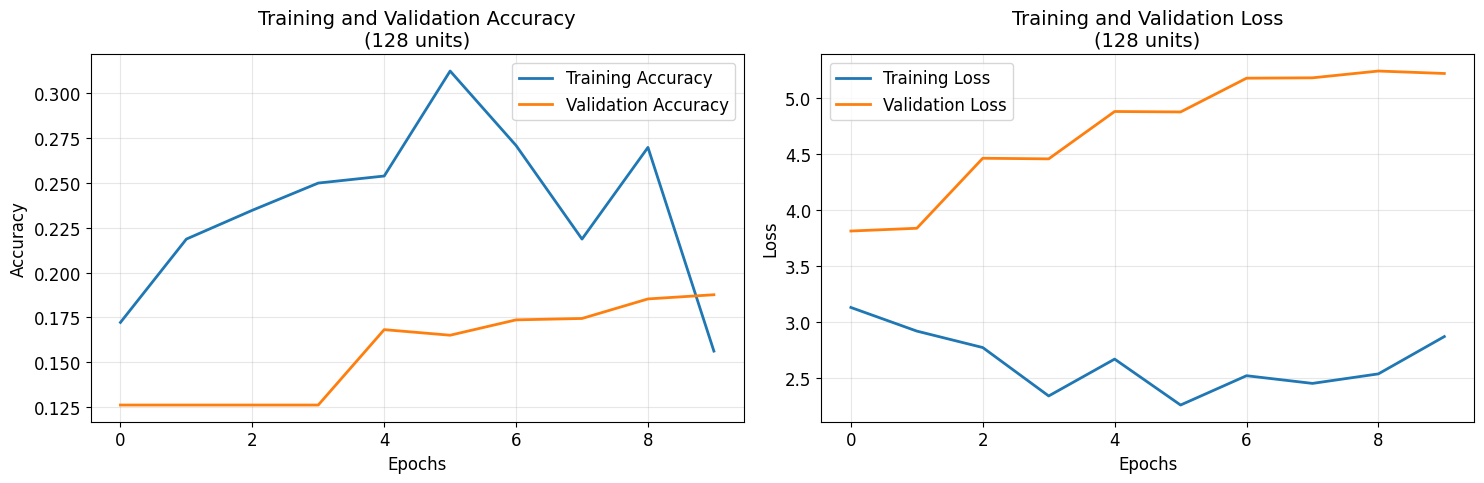

📊 Resultados para 128 unidades:
   Melhor acurácia treino: 0.3125
   Melhor acurácia validação: 0.1877

🧪 Testando com 256 unidades ocultas...

📋 Summary do modelo (256 unidades):


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_24 (Conv2D)              │ (None, 128, 128, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_30          │ (None, 128, 128, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_25 (Conv2D)              │ (None, 128, 128, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_31          │ (None, 128, 128, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_12 (MaxPooling2D) │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_18 (Dropout)            │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_26 (Conv2D)              │ (None, 64, 64, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_32          │ (None, 64, 64, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_27 (Conv2D)              │ (None, 64, 64, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_33          │ (None, 64, 64, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_13 (MaxPooling2D) │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_19 (Dropout)            │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_28 (Conv2D)              │ (None, 32, 32, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_34          │ (None, 32, 32, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_29 (Conv2D)              │ (None, 32, 32, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_35          │ (None, 32, 32, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_14 (MaxPooling2D) │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_20 (Dropout)            │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_30 (Conv2D)              │ (None, 16, 16, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_36          │ (None, 16, 16, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_31 (Conv2D)              │ (None, 16, 16, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 9,701,672 (37.01 MB)

 Trainable params: 9,698,216 (37.00 MB)

 Non-trainable params: 3,456 (13.50 KB)

Epoch 1/50
120/120 ━━━━━━━━━━━━━━━━━━━━ 298s 2s/step - accuracy: 0.1678 - loss: 3.2061 - val_accuracy: 0.1262 - val_loss: 3.8415 - learning_rate: 5.0000e-05
Epoch 2/50
120/120 ━━━━━━━━━━━━━━━━━━━━ 20s 151ms/step - accuracy: 0.1875 - loss: 3.0695 - val_accuracy: 0.1262 - val_loss: 3.8635 - learning_rate: 5.0000e-05
Epoch 3/50
120/120 ━━━━━━━━━━━━━━━━━━━━ 283s 2s/step - accuracy: 0.2199 - loss: 2.8738 - val_accuracy: 0.1262 - val_loss: 5.1809 - learning_rate: 5.0000e-05
Epoch 4/50
120/120 ━━━━━━━━━━━━━━━━━━━━ 20s 148ms/step - accuracy: 0.2812 - loss: 2.5872 - val_accuracy: 0.1262 - val_loss: 5.2210 - learning_rate: 5.0000e-05
Epoch 5/50
120/120 ━━━━━━━━━━━━━━━━━━━━ 280s 2s/step - accuracy: 0.2359 - loss: 2.7212 - val_accuracy: 0.1721 - val_loss: 4.5705 - learning_rate: 5.0000e-05
Epoch 6/50
120/120 ━━━━━━━━━━━━━━━━━━━━ 20s 148ms/step - accuracy: 0.1562 - loss: 2.6678 - val_accuracy: 0.1713 - val_loss: 4.5897 - learning_rate: 1.0000e-05
Epoch 7/50
120/120 ━━━━━━━━━━━━━━━━━━━━ 282s 2s/step

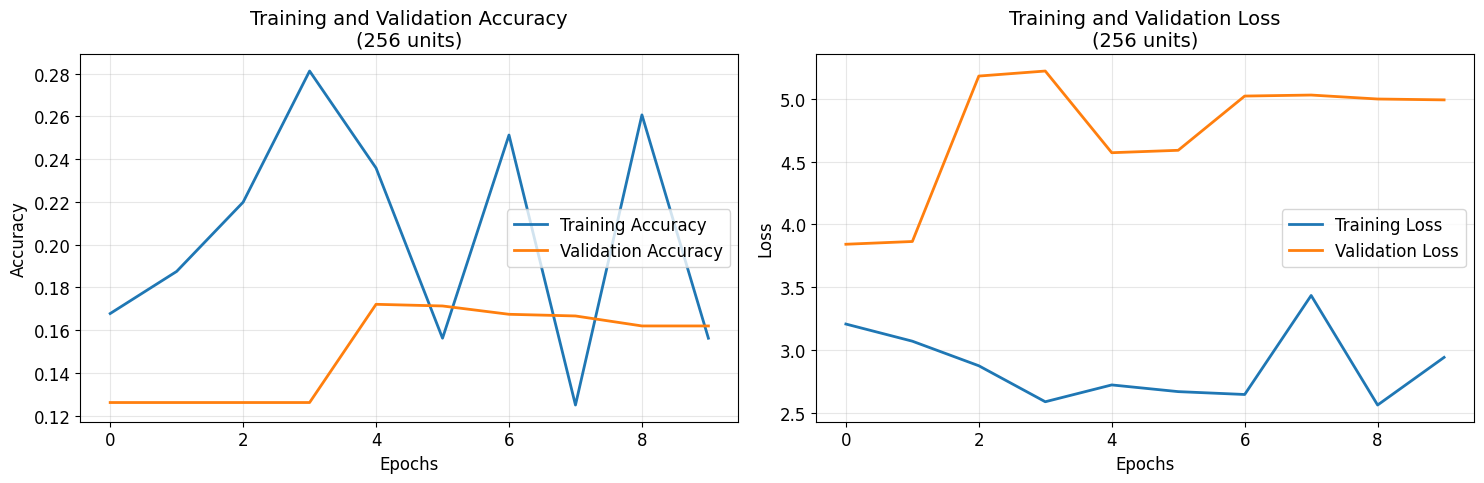

📊 Resultados para 256 unidades:
   Melhor acurácia treino: 0.2812
   Melhor acurácia validação: 0.1721

📈 COMPARAÇÃO FINAL DAS ARQUITETURAS:
   32 unidades: 0.1947 acurácia
   64 unidades: 0.1472 acurácia
   128 unidades: 0.1877 acurácia
   256 unidades: 0.1721 acurácia

🏆 MELHOR ARQUITETURA: 32 unidades ocultas
🎯 Melhor acurácia de validação: 0.1947

🎓 Treinando modelo final...
Epoch 1/100
120/120 ━━━━━━━━━━━━━━━━━━━━ 306s 2s/step - accuracy: 0.1641 - loss: 3.1929 - val_accuracy: 0.1262 - val_loss: 3.3228 - learning_rate: 5.0000e-05
Epoch 2/100
120/120 ━━━━━━━━━━━━━━━━━━━━ 20s 151ms/step - accuracy: 0.2188 - loss: 3.2002 - val_accuracy: 0.1262 - val_loss: 3.3445 - learning_rate: 5.0000e-05
Epoch 3/100
120/120 ━━━━━━━━━━━━━━━━━━━━ 283s 2s/step - accuracy: 0.1990 - loss: 2.9412 - val_accuracy: 0.1262 - val_loss: 4.3979 - learning_rate: 5.0000e-05
Epoch 4/100
120/120 ━━━━━━━━━━━━━━━━━━━━ 20s 148ms/step - accuracy: 0.1875 - loss: 2.7066 - val_accuracy: 0.1262 - val_loss: 4.3984 - learning

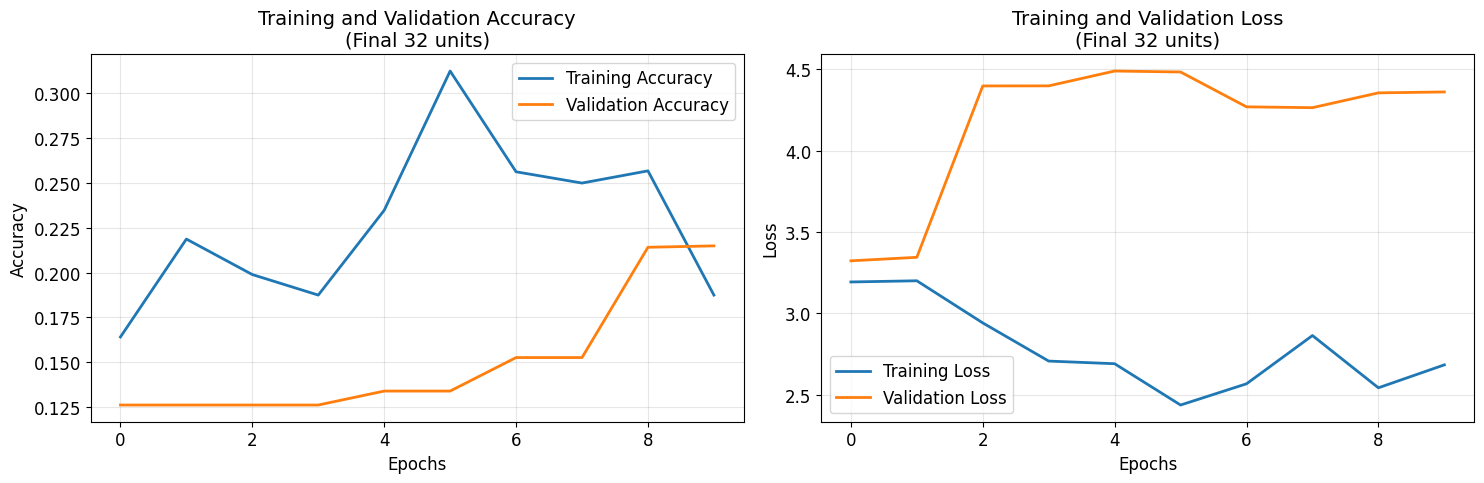


✅ ACURÁCIA FINAL NO TESTE: 0.1262
❌ RESULTADO RUIM: Acurácia abaixo de 50%
   Possíveis causas:
   - Poucas imagens por classe
   - MLP não é adequado para imagens
   - Tente usar CNN em vez de MLP

📋 SUMMARY DO MODELO FINAL:


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_32 (Conv2D)              │ (None, 128, 128, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_40          │ (None, 128, 128, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_33 (Conv2D)              │ (None, 128, 128, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_41          │ (None, 128, 128, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_16 (MaxPooling2D) │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_24 (Dropout)            │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_34 (Conv2D)              │ (None, 64, 64, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_42          │ (None, 64, 64, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_35 (Conv2D)              │ (None, 64, 64, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_43          │ (None, 64, 64, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_17 (MaxPooling2D) │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_25 (Dropout)            │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_36 (Conv2D)              │ (None, 32, 32, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_44          │ (None, 32, 32, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_37 (Conv2D)              │ (None, 32, 32, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_45          │ (None, 32, 32, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_18 (MaxPooling2D) │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_26 (Dropout)            │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_38 (Conv2D)              │ (None, 16, 16, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_46          │ (None, 16, 16, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_39 (Conv2D)              │ (None, 16, 16, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 29,098,106 (111.00 MB)

 Trainable params: 9,698,216 (37.00 MB)

 Non-trainable params: 3,456 (13.50 KB)

 Optimizer params: 19,396,434 (73.99 MB)

In [6]:
# ================== USO PRÁTICO ==================
def main():
    # 1. Carregar imagens da pasta
    dataset_folder = "pasta de teste"
    
    print("Carregando imagens...")
    X, y, class_names = load_images_from_folder(dataset_folder)
    
    # Executar diagnóstico
    if not diagnosticar_dados(X, y, class_names):
        print("❌ Problemas encontrados nos dados. Corrija antes de continuar.")
        return
    
    print(f"\nCarregadas {len(X)} imagens de {len(class_names)} classes")

     # 2. Dividir dados em TREINO, VALIDAÇÃO e TESTE
    X_train, X_temp, y_train, y_temp = train_test_split(
        X, y, test_size=0.4, random_state=42, stratify=y
    )
    
    X_val, X_test, y_val, y_test = train_test_split(
        X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp
    )
    
    print(f"📊 Dados divididos:")
    print(f"   Treino: {len(X_train)} imagens")
    print(f"   Validação: {len(X_val)} imagens")
    print(f"   Teste: {len(X_test)} imagens")

    # Criar data augmentation
    datagen = ImageDataGenerator(
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest'
    )
    
    # Ajustar o data augmentation aos dados de treino
    datagen.fit(X_train)
    
    # Callbacks para melhor treinamento
    callbacks = [
        EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
        ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.00001)
    ]
    
    # 3. Encontrar melhor arquitetura
    best_accuracy = 0
    best_units = 0
    all_val_accuracies = []
    all_units = [32, 64, 128, 256]
    
    for hidden_units in all_units:
        print(f"\n" + "="*50)
        print(f"🧪 Testando com {hidden_units} unidades ocultas...")
        
        model = create_img_cnn(X_train[0].shape, len(class_names), hidden_units)
        
        # Mostrar summary do modelo
        print(f"\n📋 Summary do modelo ({hidden_units} unidades):")
        model.summary()
        
        # Treinar
        history = model.fit(
                          datagen.flow(X_train, y_train, batch_size=BATCH_SIZE),
                          epochs=EPOCHS,
                        #   batch_size=BATCH_SIZE,
                        #   validation_split=0.2,
                          validation_data=(X_val, y_val),
                          steps_per_epoch=len(X_train) // BATCH_SIZE,
                          callbacks=callbacks,
                          verbose=1)
        
        # Plotar gráfico
        plot_training_history(history, hidden_units)
        
        # Avaliar
        val_accuracy = max(history.history['val_accuracy'])
        train_accuracy = max(history.history['accuracy'])
        all_val_accuracies.append(val_accuracy)
        
        print(f"📊 Resultados para {hidden_units} unidades:")
        print(f"   Melhor acurácia treino: {train_accuracy:.4f}")
        print(f"   Melhor acurácia validação: {val_accuracy:.4f}")
        
        if val_accuracy > best_accuracy:
            best_accuracy = val_accuracy
            best_units = hidden_units
            
    # Plotar comparação entre arquiteturas
    print(f"\n📈 COMPARAÇÃO FINAL DAS ARQUITETURAS:")
    for units, acc in zip(all_units, all_val_accuracies):
        print(f"   {units} unidades: {acc:.4f} acurácia")
    
    # 4. Treinar modelo final
    print(f"\n" + "="*50)
    print(f"🏆 MELHOR ARQUITETURA: {best_units} unidades ocultas")
    print(f"🎯 Melhor acurácia de validação: {best_accuracy:.4f}")
    
    final_model = create_img_cnn(X_train[0].shape, len(class_names), best_units)
    
    # Treinar por mais tempo
    print("\n🎓 Treinando modelo final...")
    history_final = final_model.fit(
                   datagen.flow(X_train, y_train, batch_size=BATCH_SIZE),
                   epochs=EPOCHS*2,
                #    batch_size=BATCH_SIZE,
                   validation_data=(X_val, y_val),
                   steps_per_epoch=len(X_train) // BATCH_SIZE,
                   callbacks=callbacks,
                   verbose=1)
    
    # Plotar resultados finais
    plot_training_history(history_final, f"Final {best_units}")

    # 5. Avaliar no teste
    test_loss, test_acc = final_model.evaluate(X_test, y_test, verbose=0)
    print(f"\n✅ ACURÁCIA FINAL NO TESTE: {test_acc:.4f}")
    
    if test_acc < 0.5:
        print("❌ RESULTADO RUIM: Acurácia abaixo de 50%")
        print("   Possíveis causas:")
        print("   - Poucas imagens por classe")
        print("   - MLP não é adequado para imagens")
        print("   - Tente usar CNN em vez de MLP")
    elif test_acc < 0.7:
        print("⚠️  Resultado regular: Acurácia entre 50-70%")
    elif test_acc < 0.9:
        print("✅ Resultado bom: Acurácia entre 70-90%")
    else:
        print("🎉 Excelente resultado: Acurácia acima de 90%!")

    # 6. Mostrar summary final
    print(f"\n📋 SUMMARY DO MODELO FINAL:")
    final_model.summary()

if __name__ == "__main__":
    # Configurações de visualização
    plt.style.use('default')
    plt.rcParams['figure.figsize'] = (10, 6)
    plt.rcParams['font.size'] = 12
    
    main()